In [63]:
import mne
import numpy as np
import pandas as pd
import os
from scipy import signal

# What is this file

This is my first try to process our Unicorn recordings into a format suitable for the TinySleepNet model. It takes one CSV file and saves a NPZ file which should be ready to give to the `predict.py` of TinySleepNet.

### NOT YET TESTED!

# Main info

TiniSleepNet uses the Fpz-Cz channel for predictions. That means, the informative channel is Fpz and the reference is Cz.

Unicorn does not provide Fpz channel. Fpz-Cz is unavailable for us.

The other channel in the training data is Pz-Oz. We can use it instead.

So, we need to re-train the TiniSleepNet on this channel.

## Read the CSV data

In [47]:
path = 'data/unicorncsv/test.csv'
df = pd.read_csv(path, usecols=['EEG 1', 'EEG 2', 'EEG 3', 'EEG 4',
                                'EEG 5', 'EEG 6', 'EEG 7', 'EEG 8',
                                'Validation Indicator'])

unicorn_ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
df.columns = unicorn_ch_names + ['validation']

df[unicorn_ch_names] = df[unicorn_ch_names] * 1e-6   # Unicorn returns uV, convert to V for MNE
# TODO: recheck if we need to do this step in this case!!

df.head()

,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,validation
0,-2.578000e-06,0.000003,0.000041,0.000012,-1.254500e-05,-2.202000e-06,0.000004,-0.000007,1.0
1,-1.209000e-06,0.000003,-0.000007,0.000016,-1.111200e-05,-6.300000e-07,0.000006,-0.000007,1.0
2,-7.470000e-07,0.000003,-0.000059,0.000019,-7.593000e-06,-4.540000e-07,0.000007,-0.000008,1.0
3,-1.030000e-06,0.000003,-0.000092,0.000018,-2.965000e-06,-1.718000e-06,0.000005,-0.000009,1.0
4,-1.631000e-06,0.000003,-0.000091,0.000014,6.710000e-07,-3.821000e-06,0.000003,-0.000010,1.0


## OLD: Create MNE object
**Note:** it is unnecesarry, as the model uses numpy arrays

In [39]:
ch_types = ['eeg'] * 8 + ['stim']

info = mne.create_info(ch_names=df.columns.tolist(), 
                       sfreq=250, 
                       ch_types=ch_types)
info.set_montage('standard_1020')

raw = mne.io.RawArray(df.transpose(), 
                      info)

Creating RawArray with float64 data, n_channels=9, n_times=1616168
    Range : 0 ... 1616167 =      0.000 ...  6464.668 secs
Ready.


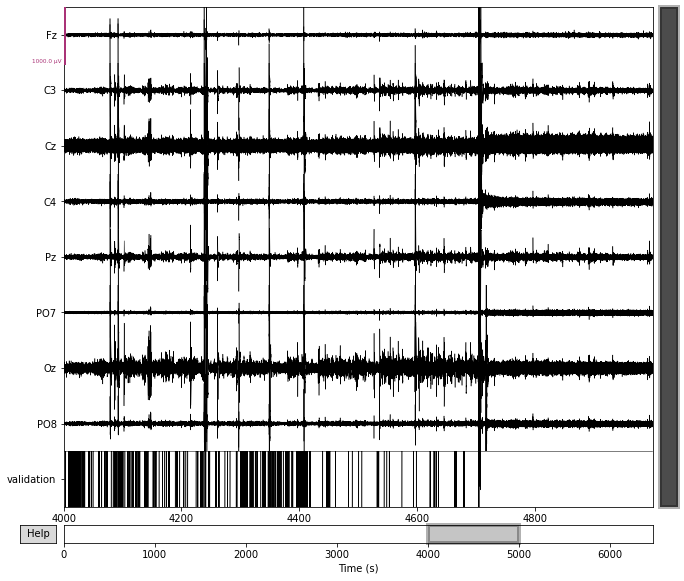

In [40]:
raw.plot(duration=1000, start=4000, scalings={'eeg': 5e-4});

In [41]:
events = mne.find_events(raw, stim_channel='validation', initial_event=True)

2722 events found
Event IDs: [1]


# Doing the same thing but without MNE

### Rereferencing to get Pz-Oz

In [57]:
Pz_Oz = df['Pz'] - df['Oz']

### Getting only good segments

In [67]:
good_data = []
idx = df[df['validation'].diff().isin([1, -1])].index.tolist()
idx.insert(0, 0)
idx.append(len(df))

for i_start, i_end in zip(idx[::2], idx[1::2]):
    good_data.append(Pz_Oz[i_start:i_end-1])
    
lens = [len(x) for x in good_data]
print(f'N segments: {len(good_data)} with length from {min(lens)} to {max(lens)} points')

N segments: 2722 with length from 7 to 604967 points


### Cutting segments into correct shape for the model

The sampling rate in the model was 100, but we have 250. We need to resample the data first.

In the model, each segments contains 30 seconds, that is 3000 time points.

All smaller segments should be dropped, and bigger segments - cut into smaller.

**TODO** check matavimo vienetai

In [74]:
segments = [signal.resample(x, round(len(x)/250*100)) for x in good_data]
lens = [len(x) for x in segments]
print(f'Resampled segments are with length from {min(lens)} to {max(lens)} points')

X = []
for segment in segments:  # get overlapping segments with 3000 points each (overlap in half)
    for i in range(len(segment) // 1500):
        X.append(segment[i * 1500 : i * 1500 + 3000])
X = [x for x in X if len(x)==3000]
print(f'Got {len(X)} segments with length of 3000 points each')

Resampled segments are with length from 3 to 241987 points
Got 317 segments with length of 3000 points each


### Saving the segments in the correct format
* X: our segments as an array
* Y: some dummy values as we are predicting only
* fs: 100
* ch_label: 'EEG Pz-Oz'
* start_datetime: not important, so some random date
* file_duration: the duration of the total file
* epoch_duration: 30 s
* n_all_epochs: not sure, number of segments? (in the train file, some epochs are dropped of, and this is the number of total epochs)
* n_epochs: number of segments

In [75]:
save_dict = {
    "x": np.array(X), 
    "y": np.array([0] * len(X)), 
    "fs": 100,
    "ch_label": 'EEG Pz-Oz',
    "start_datetime": 'none',
    "file_duration": len(df) / 250,
    "epoch_duration": 30,
    "n_all_epochs": len(X),
    "n_epochs": len(X),
}
filename = 'test.npz'
np.savez(filename, **save_dict)